# GABA Side Learning Y-maze

## Load packages

In [1]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(emmeans) # Post-hoc analysis on the model
require(DHARMa) # Evaluate model fit
require(AICcmodavg) # For model selection and averaging

Loading required package: reshape2

Loading required package: lme4

Loading required package: Matrix

Loading required package: emmeans

Loading required package: DHARMa

This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: AICcmodavg


Attaching package: ‘AICcmodavg’


The following object is masked from ‘package:lme4’:

    checkConv




## Clean-up

In [2]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

## Load data

In [3]:
ELP = read.csv("./Data/All/ELP_all.csv")
ELP = subset(ELP, ELP$Experiment == "3") # Subset for GABA experiment
head(ELP, n = 1) # Check it was loaded correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full,Experiment,Initial_Binary,Final_Binary,Switched_Binary,TSM_Bin
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
645,11.04.22,09:00,Laura Neubauer,23.9,5th November - Spain,4-days,32,29,1,2,⋯,11,500,9.8,NA,NA,3,1,1,0,0-30


## Ensure relevant variables are factors

In [4]:
ELP$Collection_Date = as.factor(ELP$Collection_Date)
ELP$Experimentor = as.factor(ELP$Experimentor)
ELP$Starvation_Period = as.factor(ELP$Starvation_Period)
ELP$Colony_ID = as.factor(paste0(ELP$Donor_Colony, "_", ELP$Recipient_Colony))
ELP$Ant_ID = as.factor(ELP$Ant_ID)

ELP$Visit = as.factor(ELP$Visit)
ELP$Solution = as.factor(ELP$Solution)
ELP$Solution = relevel(ELP$Solution, "Control")
ELP$Reward_Side = as.factor(ELP$Reward_Side)
ELP$TSM_Bin = as.factor(ELP$TSM_Bin)

ELP$Initial_Binary = as.factor(ELP$Initial_Binary)
ELP$Final_Binary = as.factor(ELP$Final_Binary)

## Identify relevant random effects

In [5]:
unique(ELP$Collection_Date)
unique(ELP$Experimentor)
unique(ELP$Starvation_Period)
unique(ELP$Colony_ID)
unique(ELP$Ant_ID)

[1] 11.04.22 12.04.22 13.04.22 14.04.22 19.04.22 20.04.22 21.04.22 22.04.22
8 Levels: 11.04.22 12.04.22 13.04.22 14.04.22 19.04.22 20.04.22 ... 22.04.22

[1] Laura Neubauer
Levels: Laura Neubauer

[1] 4-days 5-days
Levels: 4-days 5-days

[1] 32_29 16_13 35_36 9_11 
Levels: 16_13 32_29 35_36 9_11

[1] 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60 61 62 63 64
64 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 64

## Do initial and final choices significantly differ?

In [6]:
ELP_choice_diff = melt(ELP, measure.vars = c("Initial_Binary", "Final_Binary"))

ELP_choice_diff$variable = as.factor(ELP_choice_diff$variable)
ELP_choice_diff$value = as.factor(ELP_choice_diff$value)

ELP_choice_diff_mod = glmer(value ~ variable + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP_choice_diff, family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

e = emmeans(ELP_choice_diff_mod, ~variable, type = "response")
pairs(e)

boundary (singular) fit: see help('isSingular')



 contrast                      odds.ratio    SE  df null z.ratio p.value
 Initial_Binary / Final_Binary      0.937 0.193 Inf    1  -0.317  0.7512

Tests are performed on the log odds ratio scale 

p-value > 0.1 hence there is no statistical difference between initial and final decision therefore we will use final decision henceforth.

## Define models

### 1. Null model
**Biological hypothesis:** Ants randomly choose a Y-maze arm.

In [7]:
null_mod = glmer(Final_Binary ~ 1 + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 2. Visit model
**Biological hypothesis:** Ants learn to associate a Y-maze arm with a reward. Over consecutive visits more ants choose the correct arm.

In [8]:
visit_mod = glmer(Final_Binary ~ Visit + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 3. Solution model
**Biological hypothesis:** The presence of a psychoactive chemical in the reward alters the ants ability to choose a Y-maze arm.

In [9]:
solution_mod = glmer(Final_Binary ~ Solution + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 4. Side model
**Biological hypothesis:** Ants have an intrinsic predisposition towards turning left or right. This is associated with brain lateralisation which has been shown in multiple organisms.

In [10]:
side_mod = glmer(Final_Binary ~ Reward_Side + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 5. Time since marking model
**Biological hypothesis:** Ants that had a waiting period (>30 minutes) after learning the reward/side association have different recall strenght. This should be associated with long-term memory formation which should be stronger.

In [11]:
tsm_mod = glmer(Final_Binary ~ TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 6. Solution and Visit with Time since marking model
**Biological hypothesis:** The effects of a psychoactive chemical might be time dependent.

In [12]:
solution_time_mod = glmer(Final_Binary ~ Solution + TSM_Bin + Visit + Solution:TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 7. Maximal model
**Biological hypothesis:** All of the available variables contribute towards ant learning.

In [13]:
max_mod = glmer(Final_Binary ~ Solution + Visit + TSM_Bin + Reward_Side + Solution:TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



## Check if the most complex model (max_mod) is a good fit to the data

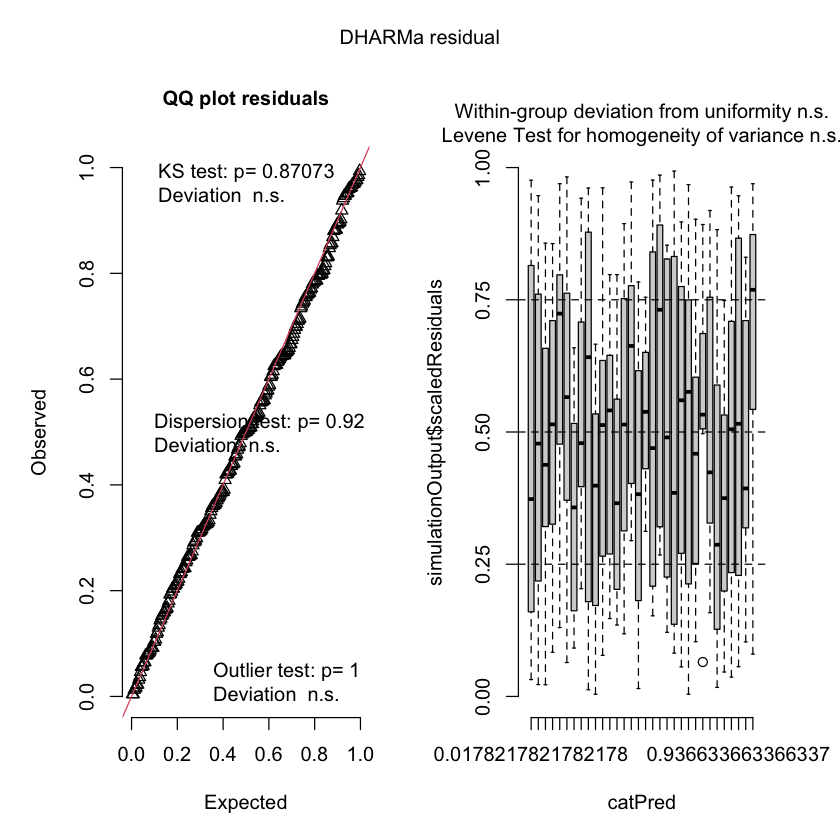

In [14]:
simres = simulateResiduals(max_mod)
plot(simres, asFactor = T)

The maximum model seems to hold all assumptions and be a god fit to the data. Therefore, all simpler models should be equally good.
## Model Selection

In [15]:
cand_models = list("null_mod" = null_mod, 
                   "visit_mod" = visit_mod,
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "tsm_mod" = tsm_mod,
                   "solution_time_mod" = solution_time_mod,
                   "max_mod" = max_mod)

aictab(cand_models)
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,visit_mod,9,334.3341,0.000000,1.00000000,0.79129092,-157.8012,0.7912909
6,solution_time_mod,12,338.8480,4.513917,0.10466836,0.08282312,-156.7820,0.8741140
7,max_mod,13,340.1339,5.799819,0.05502821,0.04354332,-156.3149,0.9176574
1,null_mod,6,340.9461,6.612049,0.03666164,0.02901002,-164.3044,0.9466674
5,tsm_mod,7,341.0481,6.714006,0.03483952,0.02756819,-163.2982,0.9742356
4,side_mod,7,342.1760,7.841956,0.01982170,0.01568473,-163.8622,0.9899203
3,solution_mod,7,343.0603,8.726287,0.01273828,0.01007969,-164.3044,1.0000000


,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,visit_mod,9,334.3341,0.000000,1.00000000,0.79129092,-157.8012,0.7912909
6,solution_time_mod,12,338.8480,4.513917,0.10466836,0.08282312,-156.7820,0.8741140
7,max_mod,13,340.1339,5.799819,0.05502821,0.04354332,-156.3149,0.9176574
1,null_mod,6,340.9461,6.612049,0.03666164,0.02901002,-164.3044,0.9466674
5,tsm_mod,7,341.0481,6.714006,0.03483952,0.02756819,-163.2982,0.9742356


**The visit_mod explains 79% of the total variance explained by all of the models tested.**

In [16]:
evidence(aic.table = aictab(cand_models))

Evidence ratio between models 'visit_mod' and 'solution_time_mod':
9.55

The visit model is 10 times more parsimonious than the next "best" model (solution_time_mod).

In [17]:
summary(visit_mod)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Binary ~ Visit + (1 | Collection_Date) + (Starvation_Period |  
    Colony_ID) + (1 | Ant_ID)
   Data: ELP
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   333.6    365.5   -157.8    315.6      247 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0455 -0.9106  0.4983  0.6571  1.1845 

Random effects:
 Groups          Name                    Variance Std.Dev. Corr
 Ant_ID          (Intercept)             0.62148  0.7883       
 Collection_Date (Intercept)             0.00000  0.0000       
 Colony_ID       (Intercept)             0.00000  0.0000       
                 Starvation_Period5-days 0.03806  0.1951    NaN
Number of obs: 256, groups:  Ant_ID, 64; Collection_Date, 8; Colony_ID, 4

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)   
(Inte

In [18]:
exp(fixef(visit_mod))

(Intercept)      Visit3      Visit4      Visit5 
   1.000152    1.671840    3.203242    3.509520

In [19]:
exp(confint(visit_mod, method = "Wald"))

,2.5 %,97.5 %
.sig01,NA,NA
.sig02,NA,NA
.sig03,NA,NA
.sig04,NA,NA
.sig05,NA,NA
(Intercept),0.5626469,1.777854
Visit3,0.7850735,3.560237
Visit4,1.4343914,7.153390
Visit5,1.5562816,7.914203


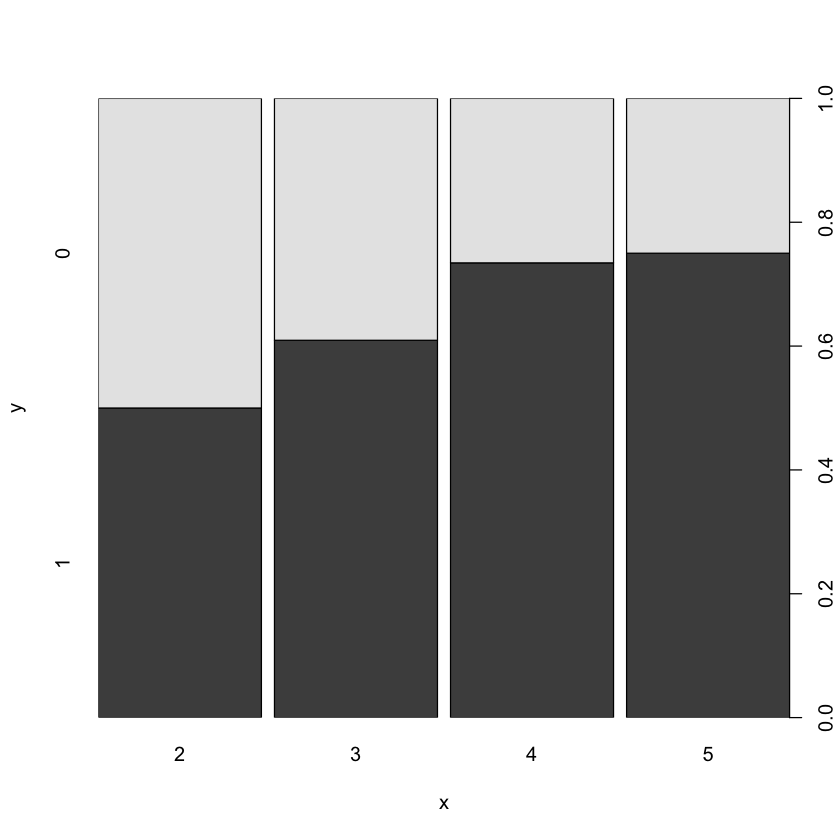

In [20]:
plot(ELP$Visit, ELP$Final_Binary)

## Initial Conclusions
- Ants randomly choose a side of the Y-maze at Visit 2 and 3 (50%/60%). However, from Visit 4 onwards ants consistently choose the rewarded side reaching 80% correct decisions.
- Visit 4 = 3.2 [1.4, 7.2] | Visit 5 = 3.5 [1.6, 7.9]
- There seems to be no side bias or effect of any other variable. However, since the Visit model explains <90% of the total variation we will do model averaging with the 95% top models.

## Brain lateralisation VS Visual Cues
**This setup had the wall on the Right!**

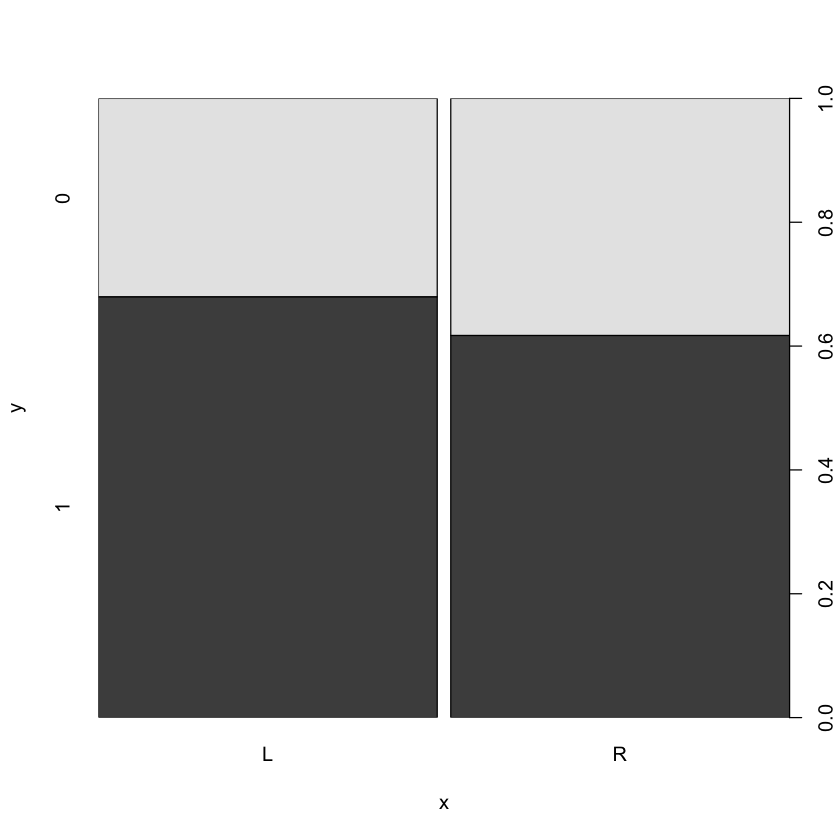

In [21]:
plot(ELP$Reward_Side, ELP$Final_Binary)

**There is a very subtle not siginificant preference for the Left side**

## Model averaging

In [22]:
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,visit_mod,9,334.3341,0.000000,1.00000000,0.79129092,-157.8012,0.7912909
6,solution_time_mod,12,338.8480,4.513917,0.10466836,0.08282312,-156.7820,0.8741140
7,max_mod,13,340.1339,5.799819,0.05502821,0.04354332,-156.3149,0.9176574
1,null_mod,6,340.9461,6.612049,0.03666164,0.02901002,-164.3044,0.9466674
5,tsm_mod,7,341.0481,6.714006,0.03483952,0.02756819,-163.2982,0.9742356


There is no longer a clearly better model!

In [23]:
top_models = list("visit_mod" = visit_mod, 
                   "solution_time_mod" = solution_time_mod,
                   "max_mod" = max_mod,
                   "null_mod" = null_mod,
                   "tsm_mod" = tsm_mod)

modavgShrink(top_models, parm = "(Intercept)")
modavg(top_models, parm = "SolutionGABA", exclude = "SolutionGABA:TSM_Bin31-60")
modavgShrink(top_models, parm = "Visit3")
modavgShrink(top_models, parm = "Visit4")
modavgShrink(top_models, parm = "Visit5")
modavg(top_models, parm = "TSM_Bin31-60", exclude = "SolutionGABA:TSM_Bin31-60")
modavgShrink(top_models, parm = "Reward_SideR")
modavgShrink(top_models, parm = "SolutionGABA:TSM_Bin31-60")

Warning message in modavgShrink.AICglmerMod(top_models, parm = "(Intercept)"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,9,334.3341,0.000000,1.00000000,0.81221723,-157.8012,0.0001520312,0.2935028
solution_time_mod,12,338.8480,4.513917,0.10466836,0.08501344,-156.7820,-0.2068200665,0.4154231
max_mod,13,340.1339,5.799819,0.05502821,0.04469486,-156.3149,-0.0397060506,0.4478047
null_mod,6,340.9461,6.612049,0.03666164,0.02977722,-164.3044,0.6837093259,0.1779948
tsm_mod,7,341.0481,6.714006,0.03483952,0.02829726,-163.2982,0.4585420247,0.2341386


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
solution_time_mod,12,338.8480,0.000000,1.0000000,0.6554202,-156.7820,-0.06775820,0.4736643
max_mod,13,340.1339,1.285902,0.5257387,0.3445798,-156.3149,-0.07333371,0.4715933


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit3"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,9,334.3341,0.000000,1.00000000,0.81221723,-157.8012,0.5139246,0.3856717
solution_time_mod,12,338.8480,4.513917,0.10466836,0.08501344,-156.7820,0.5126262,0.3852054
max_mod,13,340.1339,5.799819,0.05502821,0.04469486,-156.3149,0.5132053,0.3854584
null_mod,6,340.9461,6.612049,0.03666164,0.02977722,-164.3044,0.0000000,0.0000000
tsm_mod,7,341.0481,6.714006,0.03483952,0.02829726,-163.2982,0.0000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit4"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,9,334.3341,0.000000,1.00000000,0.81221723,-157.8012,1.164164,0.4099172
solution_time_mod,12,338.8480,4.513917,0.10466836,0.08501344,-156.7820,1.162392,0.4096570
max_mod,13,340.1339,5.799819,0.05502821,0.04469486,-156.3149,1.163613,0.4099384
null_mod,6,340.9461,6.612049,0.03666164,0.02977722,-164.3044,0.000000,0.0000000
tsm_mod,7,341.0481,6.714006,0.03483952,0.02829726,-163.2982,0.000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit5"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,9,334.3341,0.000000,1.00000000,0.81221723,-157.8012,1.255479,0.4148953
solution_time_mod,12,338.8480,4.513917,0.10466836,0.08501344,-156.7820,1.253767,0.4146811
max_mod,13,340.1339,5.799819,0.05502821,0.04469486,-156.3149,1.255067,0.4149632
null_mod,6,340.9461,6.612049,0.03666164,0.02977722,-164.3044,0.000000,0.0000000
tsm_mod,7,341.0481,6.714006,0.03483952,0.02829726,-163.2982,0.000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
solution_time_mod,12,338.8480,0.000000,1.0000000,0.5380408,-156.7820,0.4199914,0.4836260
max_mod,13,340.1339,1.285902,0.5257387,0.2828689,-156.3149,0.4194257,0.4822894
tsm_mod,7,341.0481,2.200089,0.3328563,0.1790903,-163.2982,0.4547632,0.3189086


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Reward_SideR"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,9,334.3341,0.000000,1.00000000,0.81221723,-157.8012,0.0000000,0.0000000
solution_time_mod,12,338.8480,4.513917,0.10466836,0.08501344,-156.7820,0.0000000,0.0000000
max_mod,13,340.1339,5.799819,0.05502821,0.04469486,-156.3149,-0.3289908,0.3408652
null_mod,6,340.9461,6.612049,0.03666164,0.02977722,-164.3044,0.0000000,0.0000000
tsm_mod,7,341.0481,6.714006,0.03483952,0.02829726,-163.2982,0.0000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "SolutionGABA:TSM_Bin31-60"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,9,334.3341,0.000000,1.00000000,0.81221723,-157.8012,0.0000000,0.0000000
solution_time_mod,12,338.8480,4.513917,0.10466836,0.08501344,-156.7820,0.1343106,0.6819107
max_mod,13,340.1339,5.799819,0.05502821,0.04469486,-156.3149,0.1402379,0.6795088
null_mod,6,340.9461,6.612049,0.03666164,0.02977722,-164.3044,0.0000000,0.0000000
tsm_mod,7,341.0481,6.714006,0.03483952,0.02829726,-163.2982,0.0000000,0.0000000


## Odds
**If the odds is 1 there is no effect, therefore if the CI's cross 1 that is not a significant parameter**

**Intercept** = 1.0 [0.5, 2.0] -> **Ants choose an arm of the Y-maze randomly at Visit 2!**

**Solution** = 0.93 [0.4, 2.4] -> There is no effect of Solution!

**Visit 3** = 1.6 [0.8, 3.5] -> There is no effect of Visit 3!

**Visit 4** = 3.0 [1.2, 7.7] -> **Ants at Visit 4 do not choose randomly and have an increased likelihood of choosing the reward side!**

**Visit 5** = 3.3 [1.2, 8.7] -> **Ants at Visit 4 do not choose randomly and have an increased likelihood of choosing the reward side!**

**Side** = 1.0 [0.8, 1.2] -> There is no effect of Side!

**TSM** = 1.5 [0.6, 3.8] -> There is no effect of Time Since Marking!

**SolutionxTSM** = 1.0 [0.6, 1.7] -> There is no effect of the interaction of Solution with Time Since Marking!

## Conclusions
- Ants randomly choose a Y-maze side at Visit 2 and 3 but the odds of choosing the reward side on Visit 4 and 5 increase significantly suggesting the ants are able to associate the reward with a side.
- There is no effect of Time Since Marking on final choice.
- There is no efect of GABA on final choice.
- There is no side bias.
- There is no interaction effect of Solution with Time Since Marking.